In [1]:
import pandas as pd
import re

import utils
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-colorblind')

## Functions

In [2]:
def gen_cases(metrics):
    cases = []
    for metric in metrics:
        new_name = metric.replace(" ", "_").replace('@', '')
        cases.append("max(CASE WHEN metric = '{0}' then round(value::numeric,2) else null END) as {1}".format(metric,new_name))
    return ", ".join(cases)


def table_winners(metrics, winners):
    cases = gen_cases(metrics)
    
    queries = []
    for model, vals in winners.items():
        query = ("""(WITH best{model} AS (
                      SELECT model_parameters
                      FROM results.models 
                      WHERE model_id = {id})
                        SELECT 
                           -- model_id,
                           model_type,
                           model_parameters,
                           grid_size,
                           year_train,
                           year_test,
                           cutoff,
                           {cases}
                    FROM results.models
                    JOIN best{model}
                        USING (model_parameters)
                    JOIN results.evaluations
                        USING (model_id)
                    WHERE cutoff = '{cutoff}'
                    AND ((year_train ='2000' and year_test = 2005) OR
                        (year_train = '2005' and year_test = 2010))
                    GROUP BY model_id,
                            model_type,
                            model_parameters,
                            grid_size,
                            year_train,
                            year_test,
                            cutoff)""".format(cases=cases,
                                                 model=model.lower(),
                                                id = vals['model_id'],
                                                 cutoff = vals['cutoff']))
        queries.append(query)
    query_complete =  " UNION ".join(queries)
    db_engine = utils.get_connection()
    data = pd.read_sql(query_complete, db_engine)   
    return data

def get_metres(grid_size):
    if grid_size == 'hex_grid_1000':
        return 40594.94
    elif grid_size == 'hex_grid_500':
        return 187500
    elif grid_size == 'hex_grid_250':
        return 750000
    else:
        return None
    
def normalize_costs(size, year_test, costs):
    if size == 'hex_grid_1000':
        if year_test == 2005:
            max_costs = 79176
        else:
            max_costs = 78561
            
    elif size == 'hex_grid_500':
        if year_test == 2005:
            max_costs = 239703
        else:
            max_costs = 241708
            
    else:
        if year_test == 2005:
            max_costs = 849968
        else:
            max_costs = 759175
    return costs / max_costs

In [39]:
# Params
metrics = ['recall ch@', 'precision ch@', 'cost_loss@', 'savings@', 'f1 ch@']

winners = {'RandomForest': {
                'model_id': 42, 
                'cutoff': '0.3'
              },
            'LogisticRegression': {
                'model_id': 195,
                'cutoff': '0.35'
              },
            'CostSensitiveRandomForest': {
                'model_id': 225,
                'cutoff': '0.3'
             },
           'CostSensitiveLogisticRegression': {
               'model_id': 1445,
               'cutoff': '0.45'
           }
          }

In [40]:
res = table_winners(metrics, winners)
res['meters'] = res['grid_size'].map(get_metres)
#res['cost_loss_m2'] = res['cost_loss'] / res['meters']
res['costs_normalize'] = res.apply(lambda x: normalize_costs(x['grid_size'],
                                                             x['year_test'],
                                                             x['cost_loss']), axis=1)

sortbys = ['model_type', 'meters', 'year_train', 'year_test']
res = res.sort_values(by=sortbys)
res.to_csv('resultados1.csv', index=False)

In [41]:
res

,model_type,model_parameters,grid_size,year_train,year_test,cutoff,recall_ch,precision_ch,cost_loss,savings,f1_ch,meters,costs_normalize
13,CostSensitiveLogisticRegression,"{'C': 5, 'tol': 0.01, 'solver': 'ga', 'max_ite...",hex_grid_1000,2000,2005,0.45,0.77,0.36,135728.0,-0.71,0.49,40594.94,1.714257
7,CostSensitiveLogisticRegression,"{'C': 5, 'tol': 0.01, 'solver': 'ga', 'max_ite...",hex_grid_1000,2005,2010,0.45,0.75,0.56,49865.5,0.23,0.64,40594.94,0.634736
19,CostSensitiveLogisticRegression,"{'C': 5, 'tol': 0.01, 'solver': 'ga', 'max_ite...",hex_grid_500,2000,2005,0.45,0.16,0.66,225907.0,0.06,0.26,187500.00,0.942445
11,CostSensitiveLogisticRegression,"{'C': 5, 'tol': 0.01, 'solver': 'ga', 'max_ite...",hex_grid_500,2005,2010,0.45,0.56,0.54,171096.0,0.13,0.55,187500.00,0.707862
2,CostSensitiveLogisticRegression,"{'C': 5, 'tol': 0.01, 'solver': 'ga', 'max_ite...",hex_grid_250,2000,2005,0.45,0.27,0.61,738018.0,0.13,0.37,750000.00,0.868289
0,CostSensitiveLogisticRegression,"{'C': 5, 'tol': 0.01, 'solver': 'ga', 'max_ite...",hex_grid_250,2005,2010,0.45,0.00,NaN,635755.0,0.00,0.00,750000.00,0.837429
5,CostSensitiveRandomForest,"{'pruned': True, 'combination': 'majority_voti...",hex_grid_1000,2000,2005,0.3,0.76,0.90,35044.1,0.56,0.82,40594.94,0.442610
1,CostSensitiveRandomForest,"{'pruned': True, 'combination': 'majority_voti...",hex_grid_1000,2005,2010,0.3,0.66,0.79,37832.5,0.42,0.72,40594.94,0.481568
15,CostSensitiveRandomForest,"{'pruned': True, 'combination': 'majority_voti...",hex_grid_500,2000,2005,0.3,0.64,0.83,134567.0,0.44,0.72,187500.00,0.561391
23,CostSensitiveRandomForest,"{'pruned': True, 'combination': 'majority_voti...",hex_grid_500,2005,2010,0.3,0.51,0.83,141362.0,0.28,0.63,187500.00,0.584846


In [24]:
def table_winners_allcutoffs(winners):
    cases = gen_cases(['recall ch@', 'precision ch@'])
    
    queries = []
    for model, vals in winners.items():
        query = ("""best{model} AS (
                      SELECT  
                              cutoff, 
                             year_test,
                             max(case when metric = 'precision ch@'
                                  then value else null end) as {model}_precision,
                             max(case when metric = 'recall ch@'
                                  then value else null end) as {model}_recall,
                             max(case when metric = 'true negatives ch@'
                                  then value else null end) as {model}_tn,
                             max(case when metric = 'false positives ch@'
                                  then value else null end) as {model}_fp
                      FROM results.models m1
                      join results.models m2
                      using (model_parameters)
                      join results.evaluations e
                       on m2.model_id = e.model_id
                      WHERE m1.model_id = {id}
                      and m1.model_id != m2.model_id
                      and m1.grid_size = 'hex_grid_1000'
                      and m2.grid_size = 'hex_grid_1000'
                      and m2.year_train = '2005'
                      group by cutoff, year_test)
                      """.format(model=model.lower(),
                                 id = vals['model_id']))
        queries.append(query)
    queries_first = "WITH " + ", ".join(queries)
    
    query_second = """ SELECT * FROM best{model1}""".format(model1=list(winners.keys())[0])
    query_joins = []
    for model in list(winners.keys())[1:]:
        query= (""" JOIN best{model2}
                           using(cutoff, year_test)""".format(model2=model))
        query_joins.append(query)
    
    query_final = queries_first + query_second + ' '.join(query_joins)
        
    db_engine = utils.get_connection()
    data = pd.read_sql(query_final, db_engine)   
    return data

In [29]:
res_preds = table_winners_allcutoffs(winners)
res_preds['cutoff'] = res_preds['cutoff'].map(float)
res_preds['randomforest_recall'] = res_preds['randomforest_recall'].map(float)
res_preds

,cutoff,year_test,randomforest_precision,randomforest_recall,randomforest_tn,randomforest_fp,logisticregression_precision,logisticregression_recall,logisticregression_tn,logisticregression_fp,costsensitiverandomforest_precision,costsensitiverandomforest_recall,costsensitiverandomforest_tn,costsensitiverandomforest_fp,costsensitivelogisticregression_precision,costsensitivelogisticregression_recall,costsensitivelogisticregression_tn,costsensitivelogisticregression_fp
0,0.10,2010,0.670103,0.783133,1638.0,32.0,0.563636,0.746988,1622.0,48.0,0.609091,0.807229,1627.0,43.0,0.617021,0.698795,1634.0,36.0
1,0.15,2010,0.717647,0.734940,1646.0,24.0,0.601942,0.746988,1629.0,41.0,0.685393,0.734940,1642.0,28.0,0.617021,0.698795,1634.0,36.0
2,0.20,2010,0.743590,0.698795,1650.0,20.0,0.626263,0.746988,1633.0,37.0,0.728395,0.710843,1648.0,22.0,0.617021,0.698795,1634.0,36.0
3,0.25,2010,0.750000,0.686747,1651.0,19.0,0.644444,0.698795,1638.0,32.0,0.746667,0.674699,1651.0,19.0,0.630435,0.698795,1636.0,34.0
4,0.30,2010,0.785714,0.662651,1655.0,15.0,0.674419,0.698795,1642.0,28.0,0.785714,0.662651,1655.0,15.0,0.630435,0.698795,1636.0,34.0
5,0.35,2010,0.785714,0.662651,1655.0,15.0,0.695122,0.686747,1645.0,25.0,0.808824,0.662651,1657.0,13.0,0.630435,0.698795,1636.0,34.0
6,0.40,2010,0.797101,0.662651,1656.0,14.0,0.703704,0.686747,1646.0,24.0,0.820895,0.662651,1658.0,12.0,0.630435,0.698795,1636.0,34.0
7,0.45,2010,0.820895,0.662651,1658.0,12.0,0.703704,0.686747,1646.0,24.0,0.818182,0.650602,1658.0,12.0,0.630435,0.698795,1636.0,34.0
8,0.50,2010,0.820895,0.662651,1658.0,12.0,0.714286,0.662651,1648.0,22.0,0.830769,0.650602,1659.0,11.0,0.630435,0.698795,1636.0,34.0
9,0.55,2010,0.846154,0.662651,1660.0,10.0,0.714286,0.662651,1648.0,22.0,0.841270,0.638554,1660.0,10.0,0.630435,0.698795,1636.0,34.0


In [30]:
def specificity(row, n):
    #print(row)
    sp = row.loc['{}_tn'.format(n)] / (row.loc['{}_tn'.format(n)]+ row.loc['{}_fp'.format(n)] )
    return  1-sp

res_preds['randomforest_specificity'] = res_preds.apply(lambda row: specificity(row, 'randomforest'), axis=1)
res_preds['logisticregression_specificity'] = res_preds.apply(lambda x: specificity(x, 'logisticregression'), axis=1)
res_preds['costsensitiverandomforest_specificity'] = res_preds.apply(lambda x: specificity(x, 'costsensitiverandomforest'), axis=1)
res_preds['costsensitivelogisticregression_specificity'] = res_preds.apply(lambda x: specificity(x, 'costsensitivelogisticregression'), axis=1)
res_preds

,cutoff,year_test,randomforest_precision,randomforest_recall,randomforest_tn,randomforest_fp,logisticregression_precision,logisticregression_recall,logisticregression_tn,logisticregression_fp,...,costsensitiverandomforest_tn,costsensitiverandomforest_fp,costsensitivelogisticregression_precision,costsensitivelogisticregression_recall,costsensitivelogisticregression_tn,costsensitivelogisticregression_fp,randomforest_specificity,logisticregression_specificity,costsensitiverandomforest_specificity,costsensitivelogisticregression_specificity
0,0.10,2010,0.670103,0.783133,1638.0,32.0,0.563636,0.746988,1622.0,48.0,...,1627.0,43.0,0.617021,0.698795,1634.0,36.0,0.019162,0.028743,0.025749,0.021557
1,0.15,2010,0.717647,0.734940,1646.0,24.0,0.601942,0.746988,1629.0,41.0,...,1642.0,28.0,0.617021,0.698795,1634.0,36.0,0.014371,0.024551,0.016766,0.021557
2,0.20,2010,0.743590,0.698795,1650.0,20.0,0.626263,0.746988,1633.0,37.0,...,1648.0,22.0,0.617021,0.698795,1634.0,36.0,0.011976,0.022156,0.013174,0.021557
3,0.25,2010,0.750000,0.686747,1651.0,19.0,0.644444,0.698795,1638.0,32.0,...,1651.0,19.0,0.630435,0.698795,1636.0,34.0,0.011377,0.019162,0.011377,0.020359
4,0.30,2010,0.785714,0.662651,1655.0,15.0,0.674419,0.698795,1642.0,28.0,...,1655.0,15.0,0.630435,0.698795,1636.0,34.0,0.008982,0.016766,0.008982,0.020359
5,0.35,2010,0.785714,0.662651,1655.0,15.0,0.695122,0.686747,1645.0,25.0,...,1657.0,13.0,0.630435,0.698795,1636.0,34.0,0.008982,0.014970,0.007784,0.020359
6,0.40,2010,0.797101,0.662651,1656.0,14.0,0.703704,0.686747,1646.0,24.0,...,1658.0,12.0,0.630435,0.698795,1636.0,34.0,0.008383,0.014371,0.007186,0.020359
7,0.45,2010,0.820895,0.662651,1658.0,12.0,0.703704,0.686747,1646.0,24.0,...,1658.0,12.0,0.630435,0.698795,1636.0,34.0,0.007186,0.014371,0.007186,0.020359
8,0.50,2010,0.820895,0.662651,1658.0,12.0,0.714286,0.662651,1648.0,22.0,...,1659.0,11.0,0.630435,0.698795,1636.0,34.0,0.007186,0.013174,0.006587,0.020359
9,0.55,2010,0.846154,0.662651,1660.0,10.0,0.714286,0.662651,1648.0,22.0,...,1660.0,10.0,0.630435,0.698795,1636.0,34.0,0.005988,0.013174,0.005988,0.020359


In [31]:
vars_utiles = ['cutoff', 'randomforest_precision', 'randomforest_recall', 'logisticregression_precision',
              'logisticregression_recall', 'costsensitiverandomforest_precision', 'costsensitiverandomforest_recall',
              'randomforest_specificity', 'logisticregression_specificity', 'costsensitiverandomforest_specificity',
              'costsensitivelogisticregression_precision', 'costsensitivelogisticregression_recall',
              'costsensitivelogisticregression_specificity']
res_preds = res_preds[vars_utiles]
res_preds.head()

,cutoff,randomforest_precision,randomforest_recall,logisticregression_precision,logisticregression_recall,costsensitiverandomforest_precision,costsensitiverandomforest_recall,randomforest_specificity,logisticregression_specificity,costsensitiverandomforest_specificity,costsensitivelogisticregression_precision,costsensitivelogisticregression_recall,costsensitivelogisticregression_specificity
0,0.10,0.670103,0.783133,0.563636,0.746988,0.609091,0.807229,0.019162,0.028743,0.025749,0.617021,0.698795,0.021557
1,0.15,0.717647,0.734940,0.601942,0.746988,0.685393,0.734940,0.014371,0.024551,0.016766,0.617021,0.698795,0.021557
2,0.20,0.743590,0.698795,0.626263,0.746988,0.728395,0.710843,0.011976,0.022156,0.013174,0.617021,0.698795,0.021557
3,0.25,0.750000,0.686747,0.644444,0.698795,0.746667,0.674699,0.011377,0.019162,0.011377,0.630435,0.698795,0.020359
4,0.30,0.785714,0.662651,0.674419,0.698795,0.785714,0.662651,0.008982,0.016766,0.008982,0.630435,0.698795,0.020359


In [32]:
# add rows
row1 = {'cutoff': 1, 
       'randomforest_precision': 1.0, 'randomforest_recall': 0, 'randomforest_specificity': 0,
      'logisticregression_precision': 1.0, 'logisticregression_recall': 0, 'logisticregression_specificity': 1,
      'costsensitiverandomforest_precision': 1.0, 'costsensitiverandomforest_recall': 0, 
        'costsensitiverandomforest_specificity': 0, 'costsensitivelogisticregression_precision': 1.0,
        'costsensitivelogisticregression_recall': 0, 'costsensitivelogisticregression_specificity': 0
       }

row2 = {'cutoff': 0.05, 
       'randomforest_precision': .6, 'randomforest_recall': .88, 'randomforest_specificity': 1,
      'logisticregression_precision': .53, 'logisticregression_recall': .85, 'logisticregression_specificity': 1,
      'costsensitiverandomforest_precision': .57, 'costsensitiverandomforest_recall': .9,
        'costsensitiverandomforest_specificity': 1, 'costsensitivelogisticregression_precision': .5,
       'costsensitivelogisticregression_recall': .8, 'costsensitivelogisticregression_specificity': 1}

row3 = {'cutoff': 0, 
       'randomforest_precision': .6, 'randomforest_recall': 1, 'randomforest_specificity': 1,
      'logisticregression_precision': .5, 'logisticregression_recall': 1, 'logisticregression_specificity': 1,
      'costsensitiverandomforest_precision': .55, 'costsensitiverandomforest_recall': 1,
       'costsensitiverandomforest_specificity': 1, 'costsensitivelogisticregression_precision': .5,
       'costsensitivelogisticregression_recall': 1, 'costsensitivelogisticregression_specificity': 1}


res_preds2 = res_preds.append(row1, ignore_index=True)
res_preds2 = res_preds2.append(row2, ignore_index=True)
res_preds2 = res_preds2.append(row3, ignore_index=True)
res_preds2.sort_values(by='cutoff', inplace=True)
res_preds2

,cutoff,randomforest_precision,randomforest_recall,logisticregression_precision,logisticregression_recall,costsensitiverandomforest_precision,costsensitiverandomforest_recall,randomforest_specificity,logisticregression_specificity,costsensitiverandomforest_specificity,costsensitivelogisticregression_precision,costsensitivelogisticregression_recall,costsensitivelogisticregression_specificity
19,0.00,0.600000,1.000000,0.500000,1.000000,0.550000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000
18,0.05,0.600000,0.880000,0.530000,0.850000,0.570000,0.900000,1.000000,1.000000,1.000000,0.500000,0.800000,1.000000
0,0.10,0.670103,0.783133,0.563636,0.746988,0.609091,0.807229,0.019162,0.028743,0.025749,0.617021,0.698795,0.021557
1,0.15,0.717647,0.734940,0.601942,0.746988,0.685393,0.734940,0.014371,0.024551,0.016766,0.617021,0.698795,0.021557
2,0.20,0.743590,0.698795,0.626263,0.746988,0.728395,0.710843,0.011976,0.022156,0.013174,0.617021,0.698795,0.021557
3,0.25,0.750000,0.686747,0.644444,0.698795,0.746667,0.674699,0.011377,0.019162,0.011377,0.630435,0.698795,0.020359
4,0.30,0.785714,0.662651,0.674419,0.698795,0.785714,0.662651,0.008982,0.016766,0.008982,0.630435,0.698795,0.020359
5,0.35,0.785714,0.662651,0.695122,0.686747,0.808824,0.662651,0.008982,0.014970,0.007784,0.630435,0.698795,0.020359
6,0.40,0.797101,0.662651,0.703704,0.686747,0.820895,0.662651,0.008383,0.014371,0.007186,0.630435,0.698795,0.020359
7,0.45,0.820895,0.662651,0.703704,0.686747,0.818182,0.650602,0.007186,0.014371,0.007186,0.630435,0.698795,0.020359


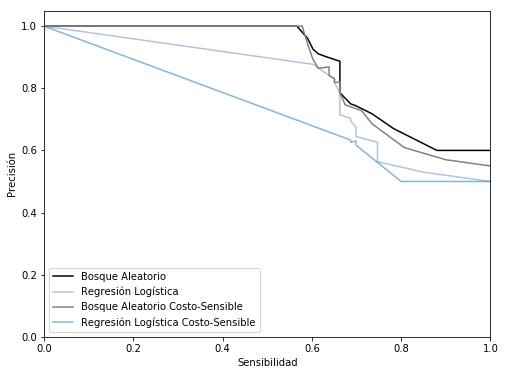

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(res_preds2['randomforest_recall'], res_preds2['randomforest_precision'],
         color='black', 
        label='Bosque Aleatorio')

#ax.plot(res_preds['randomforest_recall'], res_preds['randomforest_specificity'],
        # color='black',
#        label='Bosque Aleatorio')

ax.plot(res_preds2['logisticregression_recall'], res_preds2['logisticregression_precision'],
         color='lightsteelblue',  label = 'Regresión Logística')
        # where='post')

ax.plot(res_preds2['costsensitiverandomforest_recall'], res_preds2['costsensitiverandomforest_precision'],
         color='grey', label = 'Bosque Aleatorio Costo-Sensible')
        # where='post')
ax.plot(res_preds2['costsensitivelogisticregression_recall'], 
        res_preds2['costsensitivelogisticregression_precision'],
          label = 'Regresión Logística Costo-Sensible', alpha = .5)

ax.set_ylim([0,1.05])
ax.set_xlim([0,1])
#ax.set_title('Curva Precisión-Sensibilidad', size=20)

ax.set_xlabel('Sensibilidad', size=10)
ax.set_ylabel('Precisión', size=10)
ax.legend(loc=3, prop={'size': 10})

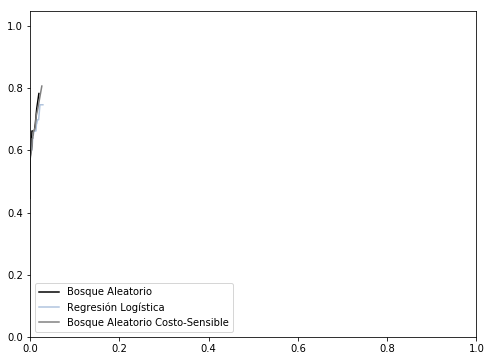

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(res_preds['randomforest_specificity'], res_preds['randomforest_recall'],
         color='black', 
        label='Bosque Aleatorio')

ax.plot(res_preds['logisticregression_specificity'], res_preds['logisticregression_recall'],
         color='lightsteelblue',  label = 'Regresión Logística')


ax.plot(res_preds['costsensitiverandomforest_specificity'], res_preds['costsensitiverandomforest_recall'],
         color='grey', label = 'Bosque Aleatorio Costo-Sensible')

ax.set_ylim([0,1.05])
ax.set_xlim([0,1])
#ax.set_title('Curva Precisión-Sensibilidad', size=20)

#ax.set_xlabel('Sensibilidad', size=10)
#ax.set_ylabel('Precisión', size=10)
ax.legend(loc=3, prop={'size': 10})